In [1]:
import pandas                   as pd
import numpy                    as np
import matplotlib.pyplot        as plt
import seaborn                  as sns
import iirsBenchmark.regressors as regressors

import Auxiliary

from IPython.display  import display
from CriticalDiagrams import draw_cd_diagram


# Setting everything up
Auxiliary.create_global_file_path_variables(results_path='../../results')
Auxiliary.set_mpl_sns_params(abnt=False)

%matplotlib inline

analyzed_path = f'../post hoc analysis files/' # Where to save the plots

## Inspectioning the Feynman data sets

,Filename,Number,Output,Formula,# variables,v1_name,v1_low,v1_high,v2_name,v2_low,...,v7_high,v8_name,v8_low,v8_high,v9_name,v9_low,v9_high,v10_name,v10_low,v10_high
0,I.6.2,2,f,exp(-(theta/sigma)**2/2)/(sqrt(2*pi)*sigma),2,sigma,1,3,theta,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,I.6.2b,3,f,exp(-((theta-theta1)/sigma)**2/2)/(sqrt(2*pi)*...,3,sigma,1,3,theta,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I.8.14,4,d,sqrt((x2-x1)**2+(y2-y1)**2),4,x1,1,5,x2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I.9.18,5,F,G*m1*m2/((x2-x1)**2+(y2-y1)**2+(z2-z1)**2),9,m1,1,2,m2,1,...,2.0,z1,3.0,4.0,z2,1.0,2.0,NaN,NaN,NaN
4,I.10.7,6,m,m_0/sqrt(1-v**2/c**2),3,m_0,1,5,v,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


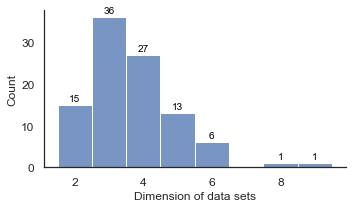

In [2]:
feynman_info = pd.read_csv(f'../../datasets/FeynmanEquations.csv')

display(feynman_info.head())

# Plotting the distribution of the number of variables
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

bins = np.arange(
    feynman_info['# variables'].min()-0.5,
    feynman_info['# variables'].max()+1,
    1
)

ax = sns.histplot(
    feynman_info['# variables'],
    ax=ax,
    bins=bins,
    kde=False
)

# Adding the number above the bar
for index, row in feynman_info.groupby('# variables')['Filename'].nunique().reset_index().iterrows():
    ax.text(
        bins[row['# variables']-1]-0.5, # x position
        row['Filename'] + 1,            # y position
        row['Filename'],                # text
        color='black', ha="center")


for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
        
ax.set_xlabel('Dimension of data sets')
ax.set_ylabel('Count')

plt.tight_layout()
plt.savefig(f'{analyzed_path}numofvariables.pdf')
plt.show()

## Post processing regression metrics results

In [3]:
def post_processing_regression_metrics(*, info_to_extract, index=False):
    """Returns an dataframe where each row is the median for each dataset
    and each column is information to extract with a suffix indicating the regressor
    (r2_test_ITEA, r2_test_Operon, ...).
    
    info_to_extract can be one of [r2_train, r2_test, rmse_train, rmse_test, tot_time]
    """
    
    # data will be a dataframe merging results for each regressor
    data = None
    for regressor in regressors.__all__ + ['Operon_regressor']:
        
        # Loading the regression results
        df_regression = pd.read_csv(f'{Auxiliary.regression_path}{regressor}.csv')

        # Here we'll group the multiple executions for each data set
        # then calculate the median for each data set. The new_df will be
        # a dataframe where the first column is the name of the data set
        # and the second column is the median of the multiple executions
        # for this data set.
        new_df = df_regression.loc[:, ['dataset', info_to_extract]].groupby(
            ['dataset']).median().reset_index(level=[0])
        
        # Cleaning the regressor name (the class name is '<name>_regressor')
        new_df.columns = ['dataset', f'{info_to_extract}_{regressor.replace("_regressor", "")}']

        # Merging the results
        data = new_df if data is None else pd.merge(data, new_df, on="dataset", how='outer')

    # deciding if the data sets should be a column or the index of the data frame
    if index:
        data.set_index('dataset', inplace=True)

    return data

r2_test


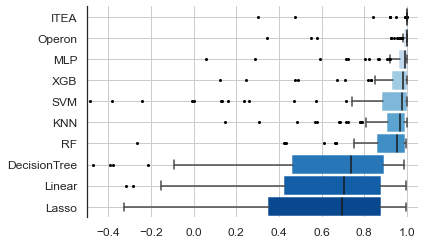

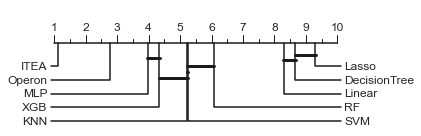

rmse_test


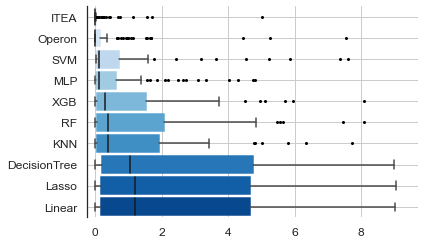

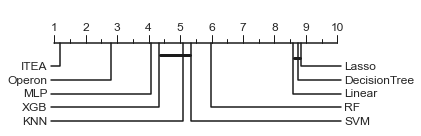

In [4]:
for info_to_extract in ['r2_test', 'rmse_test']:

    print(info_to_extract)
    
    res = post_processing_regression_metrics(info_to_extract=info_to_extract, index=True)

    res.columns = [col.replace(f'{info_to_extract}_', '') for col in res.columns]

    # Sorting the regressors by the median
    res = res[res.median().sort_values(
        ascending=(False if 'r2' in info_to_extract else True)
    ).index]

    # Boxplot ----------------------------------------------------------------
    fig, axs = plt.subplots(1, 1, figsize=(6, 3.5))

    flierprops = dict(
        marker='o', markerfacecolor='black', markersize=2, markeredgecolor='black')
    
    sns.boxplot(data=res, orient="h",medianprops={'color': 'k'},
        showfliers=True, flierprops=flierprops, ax=axs)

    reverse_cd = False
    if 'r2' in info_to_extract:
        axs.set_xlim([-0.5, 1.05])
    else:
        axs.set_xlim([-0.25, 9.7])
        reverse_cd = True

    # Creating a color gradient
    for box, color in zip(axs.artists, sns.color_palette("Blues", len(axs.artists))):
        box.set_color(color)

    axs.set_yticklabels(res.columns, fontsize = 12, ha='right')

    for spine in ['right', 'top', 'bottom']:
        axs.spines[spine].set_visible(False)

    axs.grid()

    plt.tight_layout()
    plt.savefig(f'{analyzed_path}{info_to_extract}_boxplot_traintest.pdf', bbox_inches='tight')
    plt.show()

    # Critical diagram -------------------------------------------------------
    melted_res = pd.melt(res.reset_index(), id_vars=['dataset'])
    melted_res.columns = ['dataset_name', 'classifier_name', 'accuracy']

    fig, axs = plt.subplots(1, 1, figsize=(6, 2.0))

    draw_cd_diagram(
        df_perf=melted_res, labels=False, ax=axs, width=10,
        textspace=1, reverse=reverse_cd
    )

    plt.tight_layout()
    plt.savefig(f'{analyzed_path}{info_to_extract}_criticaldiagram_traintest.pdf', bbox_inches='tight')
    plt.show()